![banniere_one](img/banniere.png)

In [ ]:
# Import des dépendances python nécessaire 

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import mlflow
import mlflow.keras

import joblib
from mlflow.models import infer_signature
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler


np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# Initialiser MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Assurez-vous que le serveur MLflow est en cours d'exécution
mlflow.start_run()

2025-05-23 15:13:13.921451: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 15:13:13.924511: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 15:13:13.932345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748005993.946191   50497 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748005993.949646   50497 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748005993.961450   50497 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<ActiveRun: >

# Exploration des données 

Ici nous allons simplement affciher une radio pour vérifier qu'on arrive à la lire. 

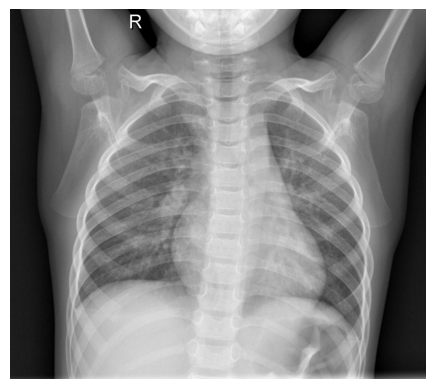

Shape (dimensions)    : (1858, 2090)
Type des valeurs      : uint8


In [2]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/train/NORMAL/IM-0115-0001.jpeg", cv2.IMREAD_GRAYSCALE)

# Observer l'image sous forme de matrice
#print(img)

# Visualisation de l'image
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")


Ici nous avons une radiographie qui est affich donc tout est bon 

# Préparation des données 

In [ ]:
def load_data(data_dir, img_read_type: int, target_size=(224, 224)):
    """
    Charge les images et les étiquettes depuis un répertoire structuré en sous-dossiers 'cat' et 'dog'.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant deux sous-dossiers : 'cat' et 'dog', chacun contenant les images correspondantes.
    img_read_type : int
        Mode de lecture des images pour OpenCV (par exemple cv2.IMREAD_GRAYSCALE ou cv2.IMREAD_COLOR).
    target_size : tuple (int, int), default=(224, 224)
        Dimensions finales souhaitées pour les images après redimensionnement.

    Returns
    -------
    X : 
        Tableau des images chargées et redimensionnées, converties en float32.
        La forme dépend du mode de lecture (grayscale ou couleur).
    
    y : 
        Tableau des labels (0 pour 'NORMAL', 1 pour 'PNEUMONIA').
    """

    X = []
    y = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible, on passe
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(label_map[label_name])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_train, y_train = load_data("data/train", cv2.IMREAD_COLOR)
X_test, y_test = load_data("data/test", cv2.IMREAD_COLOR)
X_valid, y_valid= load_data("data/val", cv2.IMREAD_COLOR)

In [ ]:
# # Les images sont au format (224, 224). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_valid = X_valid.astype("float32")

# # Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0
X_valid /= 255.0


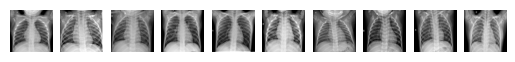

In [5]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i])
    plt.axis("off")
plt.show()

les images sont corects, on continue 

# Preprocessing

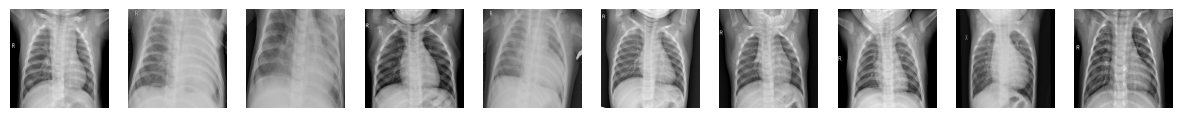

In [6]:
# Test images aléatoire 

# Supposons que X_train est votre ensemble de données d'images
# Nombre d'images à afficher
num_images = 10

# Sélectionner des indices aléatoires
random_indices = np.random.choice(len(X_train), num_images, replace=False)

# Vérification des données préparées
plt.figure(figsize=(15, 5))  # Ajustez la taille de la figure si nécessaire
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_train[idx], cmap="grey")
    plt.axis("off")

plt.show()

# Création modele 

In [7]:
# definition taille image pour model 


base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

2025-05-23 15:13:42.926442: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
features = base_model.output
features = GlobalAveragePooling2D()(features)
features = Dropout(0.3)(features)
output = Dense(1, activation='sigmoid')(features)

model = Model(inputs=base_model.input, outputs=output)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping pour éviter l'overfitting
early_stop = EarlyStopping(patience=4, restore_best_weights=True)

# Enregistrer les paramètres
mlflow.log_param("epochs", 6)
mlflow.log_param("batch_size", 32)
mlflow.log_param("learning_rate", 0.001)  # Si vous utilisez un learning rate spécifique

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=6,
    batch_size=32,
    callbacks=[early_stop]
)

# Évaluation
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc*100:.2f}%")

Epoch 1/6


2025-05-23 15:13:45.036359: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3140616192 exceeds 10% of free system memory.


163/163 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7980 - loss: 0.4634 - val_accuracy: 0.6250 - val_loss: 0.6790
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9096 - loss: 0.2243 - val_accuracy: 0.6250 - val_loss: 0.6508
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9307 - loss: 0.1768 - val_accuracy: 0.6875 - val_loss: 0.6820
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9376 - loss: 0.1632 - val_accuracy: 0.6875 - val_loss: 0.5107
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9363 - loss: 0.1654 - val_accuracy: 0.6875 - val_loss: 0.6217
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9430 - loss: 0.1532 - val_accuracy: 0.6875 - val_loss: 0.6974
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6926 - loss: 0.6484
Test accuracy: 83.01%


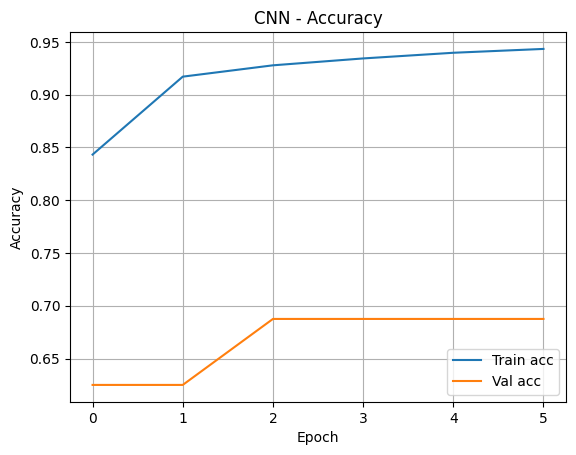

In [10]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("CNN - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Enregistrer les métriques
mlflow.log_metric("test_loss", loss)
mlflow.log_metric("test_accuracy", acc)

In [12]:
# Défreezer les 20 dernières couches du modèle 
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompiler avec un learning rate plus petit
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# Nouveau early stopping
early_stop_fine = EarlyStopping(patience=3, restore_best_weights=True)

history_finetune = model.fit(X_train, y_train,
                             validation_data=(X_valid, y_valid),
                             epochs=10,
                             batch_size=32,
                             callbacks=[early_stop_fine])

# Évaluation
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc*100:.2f}%")

Epoch 1/10


2025-05-23 15:35:09.642040: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3140616192 exceeds 10% of free system memory.


163/163 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9363 - loss: 0.1631 - val_accuracy: 0.5625 - val_loss: 0.8334
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9819 - loss: 0.0580 - val_accuracy: 0.9375 - val_loss: 0.1688
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9886 - loss: 0.0340 - val_accuracy: 0.8750 - val_loss: 0.4110
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9858 - loss: 0.0341 - val_accuracy: 1.0000 - val_loss: 0.0273
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9939 - loss: 0.0182 - val_accuracy: 0.7500 - val_loss: 0.8242
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9940 - loss: 0.0174 - val_accuracy: 0.9375 - val_loss: 0.1319
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9962 - loss: 0.0105 - val_accuracy: 0.937

In [1]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Prédictions probabilistes (sorties sigmoid)
y_probs = model.predict(X_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f"Average Precision = {avg_precision:.2f}")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

NameError: name 'model' is not defined

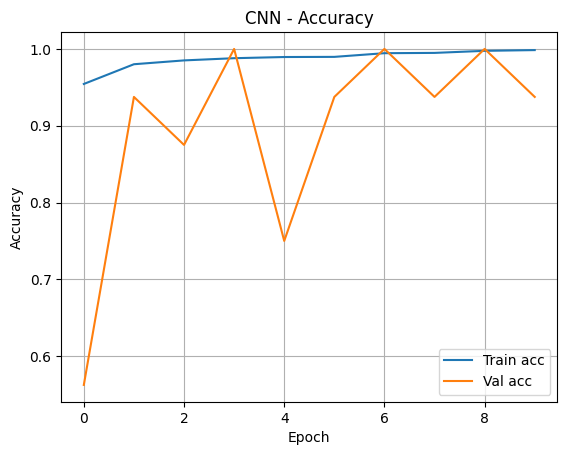

In [14]:
plt.plot(history_finetune.history['accuracy'], label='Train acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("CNN - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# test matrice confusion

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
Matrice de confusion :
[[130 104]
 [  2 388]]
Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       0.98      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



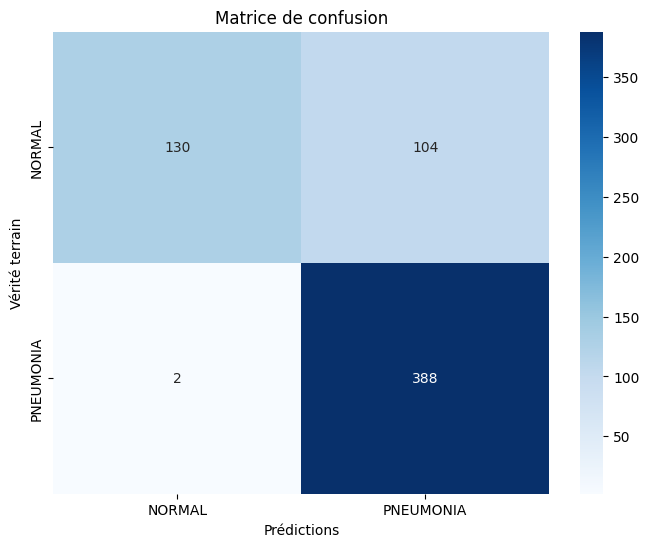

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Prédire les étiquettes pour l'ensemble de test
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

# Calculer le rapport de classification
class_report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print("Rapport de classification :")
print(class_report)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.ylabel('Vérité terrain')
plt.xlabel('Prédictions')
plt.title('Matrice de confusion')
plt.show()

# Test Mlflow

In [16]:
# Enregistrer les métriques après le fine-tuning
mlflow.log_metric("fine_tune_test_loss", loss)
mlflow.log_metric("fine_tune_test_accuracy", acc)

# Enregistrer le modèle
mlflow.keras.log_model(model, "model")

# Fin de la session MLflow
mlflow.end_run()

2025/05/23 16:14:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/23 16:14:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run able-colt-231 at: http://localhost:5000/#/experiments/0/runs/0f694a6353f14043aaeccbeaaf40729c
🧪 View experiment at: http://localhost:5000/#/experiments/0
